In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf

c:\Users\adria\miniconda3\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\adria\miniconda3\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\adria\miniconda3\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid compatibility violations i

## Lectura de datos

In [2]:
# Asegúrate de que este notebook esté en la misma carpeta que datos-enc.csv
df = pd.read_csv('datos-enc.csv', sep=';')
df.head()

,Tiempo Soleado,Tiempo Nublado,Temperatura Calor,Temperatura Frio,Humedad Alta,Viento Debil,Juega Tenis
0,1,0,1,0,1,1,0
1,1,0,1,0,1,0,0
2,0,1,1,0,1,1,1
3,0,0,0,0,1,1,1
4,0,0,0,1,0,1,1


## Formulación del modelo

En el notebook original, la variable objetivo es la columna `Juega Tenis` y el resto de columnas son las features codificadas.
Usaremos la misma formulación:

In [3]:
# Matriz de features (todas las columnas excepto la variable objetivo)
X = df.drop(columns='Juega Tenis').values

# Vector objetivo
y = df['Juega Tenis'].values

X.shape, y.shape

((14, 6), (14,))

## División train/test

Aunque el dataset es pequeño, haremos una división simple para evaluar generalización.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((10, 6), (4, 6))

## Definición del perceptrón de clasificación con TensorFlow / Keras

Un perceptrón de clasificación binaria es un modelo lineal con una neurona de salida y activación sigmoide.

En Keras lo representamos como una red `Sequential` con una sola capa `Dense` de 1 neurona y `activation='sigmoid'`.

In [5]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=(X_train.shape[1],), activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\adria\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7 (28.00 B)

 Trainable params: 7 (28.00 B)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento del modelo

In [6]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=4,
    validation_split=0.2,
    verbose=0
)

len(history.history['loss'])

50

## Haciendo predicciones

In [7]:
# Probabilidades predichas
y_train_pred_prob = model.predict(X_train).flatten()
y_test_pred_prob = model.predict(X_test).flatten()

# Convertimos probabilidades a clases 0/1 usando umbral 0.5
y_train_pred = (y_train_pred_prob >= 0.5).astype(int)
y_test_pred = (y_test_pred_prob >= 0.5).astype(int)

y_train_pred[:10], y_test_pred[:10]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


(array([0, 1, 1, 0, 1, 1, 0, 0, 1, 0]), array([1, 1, 0, 1]))

In [8]:
# Ejemplo de predicción para un vector específico (similar al notebook original)
x_ejemplo = np.array([[0, 1, 0, 0, 1, 0]])  # debe tener la misma cantidad de features que X
prob_ej = model.predict(x_ejemplo)[0, 0]
pred_ej = int(prob_ej >= 0.5)

print('Probabilidad predicha:', prob_ej)
print('Clase predicha (0/1):', pred_ej)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Probabilidad predicha: 0.6115231
Clase predicha (0/1): 1


## Evaluando el desempeño

In [9]:
# Accuracy en entrenamiento y test
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print('Accuracy entrenamiento:', acc_train)
print('Accuracy test:', acc_test)

Accuracy entrenamiento: 0.9
Accuracy test: 1.0


In [10]:
# Matrices de confusión
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

print('Matriz de confusión - Entrenamiento')
print(cm_train)

print('Matriz de confusión - Test')
print(cm_test)

Matriz de confusión - Entrenamiento
[[4 0]
 [1 5]]
Matriz de confusión - Test
[[1 0]
 [0 3]]


## Error y accuracy por epoch

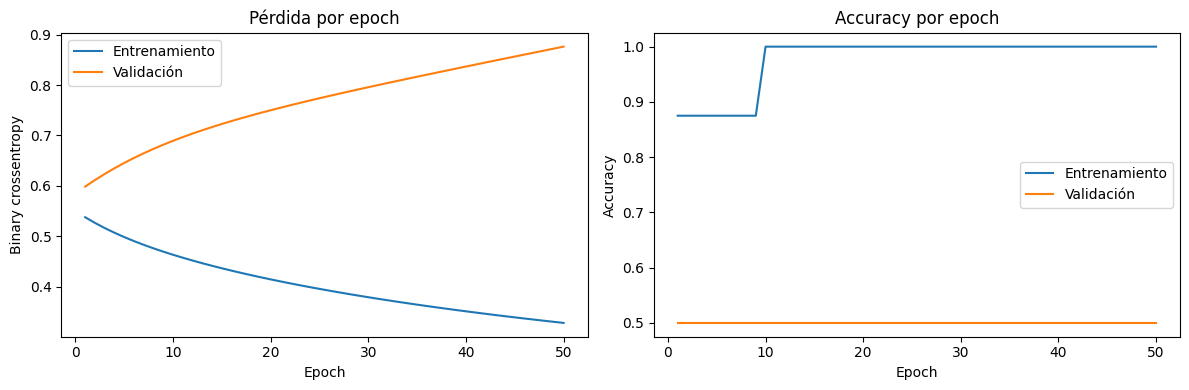

: 

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Entrenamiento')
plt.plot(epochs, val_loss, label='Validación')
plt.xlabel('Epoch')
plt.ylabel('Binary crossentropy')
plt.title('Pérdida por epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Entrenamiento')
plt.plot(epochs, val_acc, label='Validación')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy por epoch')
plt.legend()

plt.tight_layout()
plt.show()

### Comentarios

- Este modelo es equivalente al perceptrón de clasificación implementado "a mano", pero usando TensorFlow/Keras para el cálculo de gradientes y la actualización de pesos.
- Puedes modificar parámetros como `learning_rate`, `epochs` y `batch_size` para ver cómo cambia el desempeño.
- También podrías añadir más neuronas o capas para experimentar con modelos algo más complejos.